In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [24]:
data = pd.read_csv(r'D:\TimeSeries\intermittent-renewables-production-france.csv')

data

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July
...,...,...,...,...,...,...,...,...,...
59801,2023-06-30 06:00:00+02:00,2023-06-30,06:00:00,07:00:00,Solar,55.0,181,Friday,June
59802,2023-06-30 13:00:00+02:00,2023-06-30,13:00:00,14:00:00,Solar,4554.0,181,Friday,June
59803,2023-06-30 14:00:00+02:00,2023-06-30,14:00:00,15:00:00,Solar,4589.0,181,Friday,June
59804,2023-06-30 16:00:00+02:00,2023-06-30,16:00:00,17:00:00,Solar,4173.0,181,Friday,June


In [25]:

def transform_time_features(df):
    """
    Safely transforms time and date features from a DataFrame.
    Handles cases where time strings may include 'na' or invalid values.
    """

    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Safely extract StartHour and EndHour from 'HH:MM:SS' or invalid strings
    df['Hour'] = pd.to_datetime(df['StartHour'], format='%H:%M:%S', errors='coerce').dt.hour

    # Extract date components
    df['dayOfYear'] = df['Date'].dt.dayofyear
    df['monthName'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['dayName'] = df['Date'].dt.weekday + 1  # Monday = 1, Sunday = 7

    return df


data_transformed = transform_time_features(data)

data_transformed

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName,Hour,Year
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,3,7,20,2020
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,4,7,7,2020
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,4,7,16,2020
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,4,7,19,2020
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,4,7,23,2020
...,...,...,...,...,...,...,...,...,...,...,...
59801,2023-06-30 06:00:00+02:00,2023-06-30,06:00:00,07:00:00,Solar,55.0,181,5,6,6,2023
59802,2023-06-30 13:00:00+02:00,2023-06-30,13:00:00,14:00:00,Solar,4554.0,181,5,6,13,2023
59803,2023-06-30 14:00:00+02:00,2023-06-30,14:00:00,15:00:00,Solar,4589.0,181,5,6,14,2023
59804,2023-06-30 16:00:00+02:00,2023-06-30,16:00:00,17:00:00,Solar,4173.0,181,5,6,16,2023


In [26]:
data_transformed = data_transformed[['Hour', 'dayName', 'dayOfYear', 'monthName', 'Year', 'Source', 'Production']]
data_transformed = data_transformed.rename(columns={
    'dayName': 'day of week',
    'monthName': 'Month'
})
data_transformed

,Hour,day of week,dayOfYear,Month,Year,Source,Production
0,20,3,204,7,2020,Solar,244.0
1,7,4,205,7,2020,Solar,223.0
2,16,4,205,7,2020,Solar,2517.0
3,19,4,205,7,2020,Solar,658.0
4,23,4,205,7,2020,Solar,0.0
...,...,...,...,...,...,...,...
59801,6,5,181,6,2023,Solar,55.0
59802,13,5,181,6,2023,Solar,4554.0
59803,14,5,181,6,2023,Solar,4589.0
59804,16,5,181,6,2023,Solar,4173.0


In [38]:
# Function to create daily aggregates
def create_daily_by_source(df):
    daily_df = df.groupby(['dayOfYear', 'Source']).agg({
        'Production': 'sum',
        'day of week': 'first',
        'Month': 'first',
    }).reset_index()
    
    # Reorder columns nicely
    daily_df = daily_df[['dayOfYear', 'Month', 'Source', 'Production']]
    
    # Sort by Year, dayOfYear, Source
    daily_df = daily_df.sort_values(by=['dayOfYear', 'Source']).reset_index(drop=True)
    return daily_df

# Create unscaled daily data
daily = create_daily_by_source(data_transformed)

daily

,dayOfYear,Month,Source,Production
0,1,1,Solar,36874.0
1,1,1,Wind,418094.0
2,2,1,Solar,27008.0
3,2,1,Wind,520981.0
4,3,1,Solar,35688.0
...,...,...,...,...
727,364,12,Wind,600318.0
728,365,12,Solar,35549.0
729,365,12,Wind,560958.0
730,366,12,Solar,4469.0


In [28]:

daily = data_transformed.sort_values(by=['Year','dayOfYear','Hour']).reset_index(drop=True)
data = daily.copy()
data_solar = data[data['Source'] == 'Solar'].drop(columns='Source').reset_index(drop=True)
data_wind = data[data['Source'] == 'Wind'].drop(columns='Source').reset_index(drop=True)

data_solar

,Hour,day of week,dayOfYear,Month,Year,Production
0,0,3,1,1,2020,0.0
1,1,3,1,1,2020,0.0
2,2,3,1,1,2020,0.0
3,3,3,1,1,2020,0.0
4,4,3,1,1,2020,0.0
...,...,...,...,...,...,...
29897,19,5,181,6,2023,1273.0
29898,20,5,181,6,2023,439.0
29899,21,5,181,6,2023,50.0
29900,22,5,181,6,2023,1.0


In [ ]:
def add_cyclical_features_drop_originals(df):
    # Create cyclical features

    df['sin_dayOfYear'] = np.sin(2 * np.pi * df['dayOfYear'] / 365)
    df['cos_dayOfYear'] = np.cos(2 * np.pi * df['dayOfYear'] / 365)

    df['sin_H= np.sin(2 * np.pi * df['Month'] / 12)
    df['cos_Month'] = np.cos(2 * np.pi * df['Month'] / 12)

    # Drop original columns
    df = df.drop(columns=['dayOfYear', 'Month'])

    return df

In [41]:
data_transformed_solar = add_cyclical_features_drop_originals(data_solar)
data_transformed_wind = add_cyclical_features_drop_originals(data_wind)

In [9]:
year_encoding = {2020: 0, 2021: 1, 2022: 2, 2023: 3}

data_transformed_solar['Year'] = data_transformed_solar['Year'].map(year_encoding)
data_transformed_wind['Year'] = data_transformed_wind['Year'].map(year_encoding)

In [42]:
from sklearn.preprocessing import MinMaxScaler

# 1. Initialize and fit scaler on Production column
scaler_solar = MinMaxScaler()
data_transformed_solar['Production'] = scaler_solar.fit_transform(data_transformed_solar[['Production']])

scaler_wind = MinMaxScaler()
data_transformed_wind['Production'] = scaler_wind.fit_transform(data_transformed_wind[['Production']])


In [43]:
data_transformed_wind

,Production,sin_dayOfYear,cos_dayOfYear,sin_Month,cos_Month
0,0.379331,1.721336e-02,0.999852,5.000000e-01,0.866025
1,0.489402,3.442161e-02,0.999407,5.000000e-01,0.866025
2,0.589057,5.161967e-02,0.998667,5.000000e-01,0.866025
3,0.613193,6.880243e-02,0.997630,5.000000e-01,0.866025
4,0.343444,8.596480e-02,0.996298,5.000000e-01,0.866025
...,...,...,...,...,...
361,0.904301,-5.161967e-02,0.998667,-2.449294e-16,1.000000
362,0.679788,-3.442161e-02,0.999407,-2.449294e-16,1.000000
363,0.574278,-1.721336e-02,0.999852,-2.449294e-16,1.000000
364,0.532170,6.432491e-16,1.000000,-2.449294e-16,1.000000


In [52]:
import numpy as np

n_past = 3  # number of past days to look at

def create_sequences(df):
    X, y = [], []
    for i in range(n_past, len(df)):
        X.append(df.iloc[i - n_past:i].values)
        y.append(df.iloc[i]['Production'])  # Access by column name
    return np.array(X), np.array(y).reshape(-1, 1)

# Generate sequences
trainX_solar, trainY_solar = create_sequences(data_transformed_solar)
trainX_wind, trainY_wind = create_sequences(data_transformed_wind)

In [53]:
# ------------------------
# 2. Train-Test Split
# ------------------------


def split_data(X, y, test_size=0.1):
    split_idx = int(len(X) * (1 - test_size))
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

X_train_solar, X_test_solar, y_train_solar, y_test_solar = split_data(trainX_solar, trainY_solar)
X_train_wind, X_test_wind, y_train_wind, y_test_wind = split_data(trainX_wind, trainY_wind)


In [54]:
# ------------------------
# 3. Define LSTM model
# ------------------------

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [55]:
# Build and train solar model
modelS = build_model((X_train_solar.shape[1], X_train_solar.shape[2]))
historyS = modelS.fit(X_train_solar, y_train_solar, epochs=5, batch_size=16,
                      validation_data=(X_test_solar, y_test_solar), verbose=1)


Epoch 1/5


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.2871 - val_loss: 0.0051
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1075 - val_loss: 0.0390
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0202 - val_loss: 0.0081
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - val_loss: 0.0065
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 - val_loss: 0.0077


In [56]:
# Build and train wind model
modelW = build_model((X_train_wind.shape[1], X_train_wind.shape[2]))
historyW = modelW.fit(X_train_wind, y_train_wind, epochs=5, batch_size=16,
                      validation_data=(X_test_wind, y_test_wind), verbose=1)


Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1067 - val_loss: 0.0305
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0283 - val_loss: 0.0338
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0218 - val_loss: 0.0276
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0201 - val_loss: 0.0287
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205 - val_loss: 0.0291


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_test, y_test, scaler, name='Model'):
    """
    Evaluates a trained model on test data. Assumes Production was the last feature,
    scaled with MinMaxScaler. Other features (e.g., cyclic encodings) are ignored.
    """
    # Predict
    y_pred = model.predict(X_test)

    # Detect how many features were used during scaling
    n_features = scaler.scale_.shape[0]  # usually just 1 (Production)

    # Pad predictions with zeros to match scaler input shape
    padded_pred = np.zeros((len(y_pred), n_features))
    padded_true = np.zeros((len(y_test), n_features))

    # Place predictions and true values into the last column (Production)
    padded_pred[:, -1] = y_pred.ravel()
    padded_true[:, -1] = y_test.ravel()

    # Inverse scale only Production
    inv_pred = scaler.inverse_transform(padded_pred)[:, -1]
    inv_true = scaler.inverse_transform(padded_true)[:, -1]

    # Metrics
    mse = mean_squared_error(inv_true, inv_pred)
    mae = mean_absolute_error(inv_true, inv_pred)
    r2 = r2_score(inv_true, inv_pred)

    print(f"📊 Evaluation for {name}:")
    print(f"   MSE:  {mse:.2f}")
    print(f"   MAE:  {mae:.2f}")
    print(f"   R²:   {r2:.4f}")

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(inv_true, label='True')
    plt.plot(inv_pred, label='Predicted')
    plt.title(f'{name} — True vs Predicted Production')
    plt.xlabel('Time Step')
    plt.ylabel('Production')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step
📊 Evaluation for Solar:
   MSE:  228130308.02
   MAE:  13708.74
   R²:   -4.5030


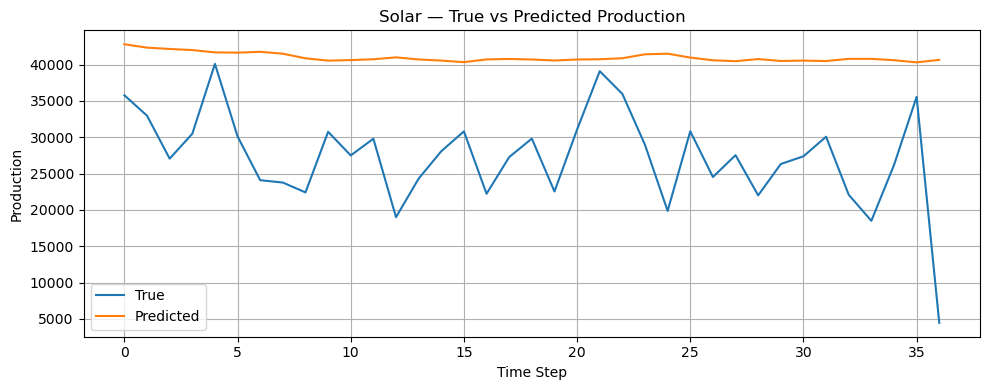

In [58]:
evaluate_model(modelS, X_test_solar, y_test_solar, scaler_solar, name='Solar')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
📊 Evaluation for Wind:
   MSE:  25453104851.77
   MAE:  125938.23
   R²:   -0.0618


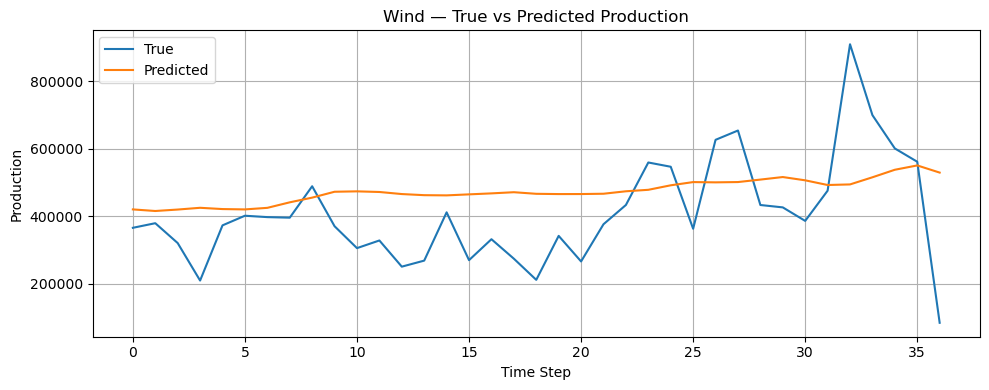

In [59]:
evaluate_model(modelW, X_test_wind, y_test_wind, scaler_wind, name='Wind')